In [ ]:
!unzip -u "drive/MyDrive/dogs_vs_cats/test1.zip" -d "drive/MyDrive/dogs_vs_cats/data"

In [ ]:
!unzip -u "drive/MyDrive/dogs_vs_cats/train.zip" -d "drive/MyDrive/dogs_vs_cats/data"

In [4]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


#🐕dog VS cat🐈 classification project

#1. Project Aim
To classify between dogs and cats

#2. Data
Using kaggle dataset :https://www.kaggle.com/competitions/dogs-vs-cats/data

Data contains : 
1. Training data contains of 25000 images
2. Test data contains 12500 images
3. Data that we're using is unstructured data
4. There are two category `dog`=1 and `cat`=0

## Importing libraries



In [1]:
import tensorflow as tf
import tensorflow_hub as hub

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
import os
import random
from sklearn.model_selection import train_test_split

from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D , Dropout, Flatten, Dense, Activation, GlobalMaxPooling2D
from keras.applications import VGG16
from keras import optimizers
from keras.models import Model
import seaborn as sns
import pickle

In [2]:
print("Tensorflow Version",tf.__version__)
print("Tensorflow Hub Version",hub.__version__)
print("GPU","Available" if tf.config.list_physical_devices("GPU") else "Not available" )

Tensorflow Version 2.12.0
Tensorflow Hub Version 0.13.0
GPU Available


## Getting our data ready(turning into tensors)

Creating our own dataset

In [5]:
filenames=os.listdir("drive/MyDrive/dogs_vs_cats/data/train")
categories=[]

for filename in filenames:
  category=filename.split(".")[0]

  if category=='dog':
    categories.append(1)
  else:
    categories.append(0)

df=pd.DataFrame({
    'Filename':filenames,
    'Category':categories
})

df.head()

,Filename,Category
0,cat.9118.jpg,0
1,cat.9113.jpg,0
2,cat.909.jpg,0
3,cat.9096.jpg,0
4,cat.9069.jpg,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23492 entries, 0 to 23491
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Filename  23492 non-null  object
 1   Category  23492 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 367.2+ KB


In [7]:
if len(os.listdir("drive/MyDrive/dogs_vs_cats/data/train"))==len(filenames):
  print("Equal files in both")
else:
  print("Not equal files")
len(filenames)

Equal files in both


23492

In [8]:
len(os.listdir("drive/MyDrive/dogs_vs_cats/data/train"))

23492

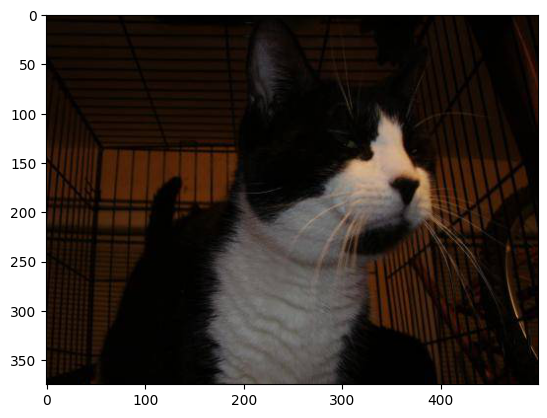

In [9]:
sample =random.choice(filenames)
img = np.asarray(Image.open("drive/MyDrive/dogs_vs_cats/data/train/"+sample))
plt.imshow(img)

Spliting data in training and validation set

In [10]:
sample_df=df[10500:14500]
sample_df

,Filename,Category
10500,cat.11795.jpg,0
10501,cat.11764.jpg,0
10502,cat.11797.jpg,0
10503,cat.11787.jpg,0
10504,cat.11781.jpg,0
...,...,...
14495,dog.6806.jpg,1
14496,dog.6812.jpg,1
14497,dog.6791.jpg,1
14498,dog.6825.jpg,1


<Axes: >

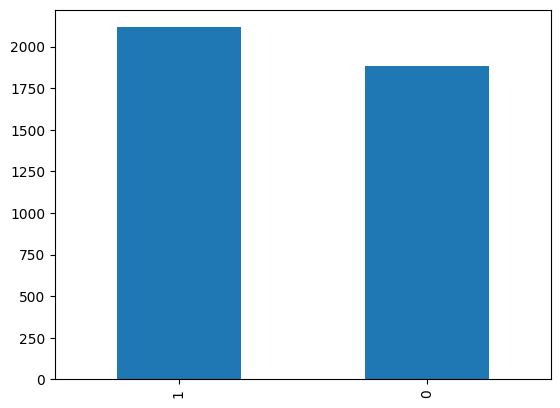

In [11]:
sample_df['Category'].value_counts().plot.bar()

In [12]:
training_data,validation_data=train_test_split(sample_df,test_size=0.2,random_state=33)
training_data=training_data.reset_index()
validation_data=validation_data.reset_index()

In [13]:
training_data.shape[0],validation_data.shape[0]

(3200, 800)

In [14]:
training_data['Category']=training_data['Category'].astype(str)
validation_data['Category']=validation_data['Category'].astype(str)

### Training Image Generator

In [15]:
img_size=225
input_shape=(img_size,img_size,3)
batch_size=32
epochs=10 #@param {type:"slider",min:10,max:100,step:10}

In [ ]:
training_datagen=ImageDataGenerator(rotation_range=20,rescale=1./255,
                                    shear_range=0.2,zoom_range=0.2,
                                    horizontal_flip=True,fill_mode='nearest',
                                    width_shift_range=0.1,
                                    height_shift_range=0.1)

training_generator = training_datagen.flow_from_dataframe(training_data, 
                                                          "drive/MyDrive/dogs_vs_cats/data/train", 
                                                          x_col='Filename',y_col='Category',
                                                          class_mode='binary',
                                                          target_size=(img_size, img_size),
                                                          batch_size=batch_size)

Found 3200 validated image filenames belonging to 2 classes.


### Validation Image Generator

In [ ]:
validation_datagen=ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(validation_data, 
    "drive/MyDrive/dogs_vs_cats/data/train", 
    x_col='Filename',y_col='Category',
    class_mode='binary',
    target_size=(img_size, img_size),
    batch_size=batch_size
)

Found 800 validated image filenames belonging to 2 classes.


<Axes: >

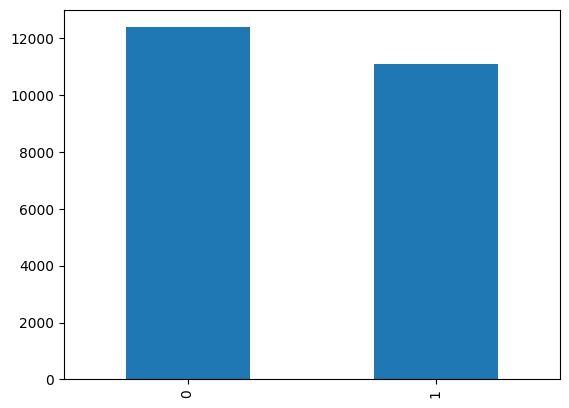

In [ ]:
df['Category'].value_counts().plot.bar()

### Augmenting `training_data` image

Creating duplicates of a image from training_data for training the model

Found 1 validated image filenames belonging to 1 classes.


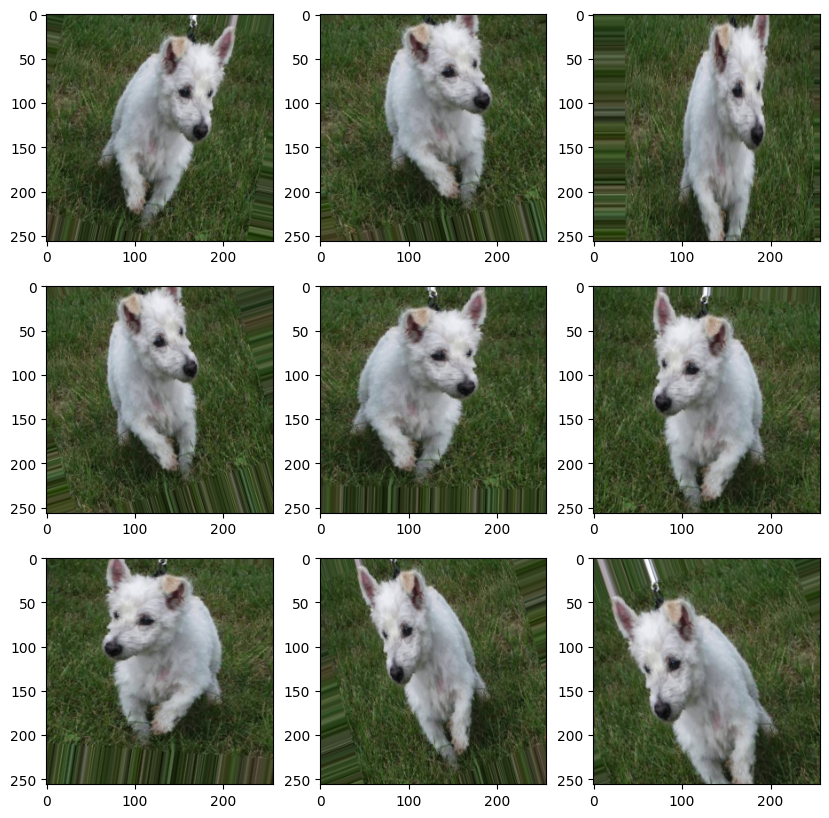

In [ ]:
sample_df=training_data.sample(n=1).reset_index(drop=True)
sample_generator=training_datagen.flow_from_dataframe(sample_df,"drive/MyDrive/dogs_vs_cats/data/train",
                                                      x_col='Filename',y_col='Category',
                                                      class_mode='categorical')
plt.figure(figsize=(10,10))
for i in range(0,9):
  plt.subplot(3,3,i+1)
  for img, label in sample_generator:
    image=img[0]
    plt.imshow(image)
    break

plt.show()

## Training the model

Using a pre-trained VGG16 model:https://www.mathworks.com/help/deeplearning/ref/vgg16.html



In [ ]:
VGG16_model=VGG16(input_shape=input_shape,
                  include_top=False,
                  weights="imagenet")

for layer in VGG16_model.layers[:15]:
  layer.trainable=False

for layer in VGG16_model.layers[15:]:
  layer.trainable=True

last_layer=VGG16_model.get_layer('block5_pool')
last_output=last_layer.output

clf=GlobalMaxPooling2D()(last_output)
clf=Dense(512,activation='relu')(clf)
clf=Dropout(0.5)(clf)
clf=layers.Dense(1,activation='sigmoid')(clf)

model=Model(VGG16_model.input,clf)
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4,momentum=0.9),
              metrics='accuracy')

model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 225, 225, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 225, 225, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 225, 225, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.0/992.0 KB 21.3 MB/s eta 0:00:00


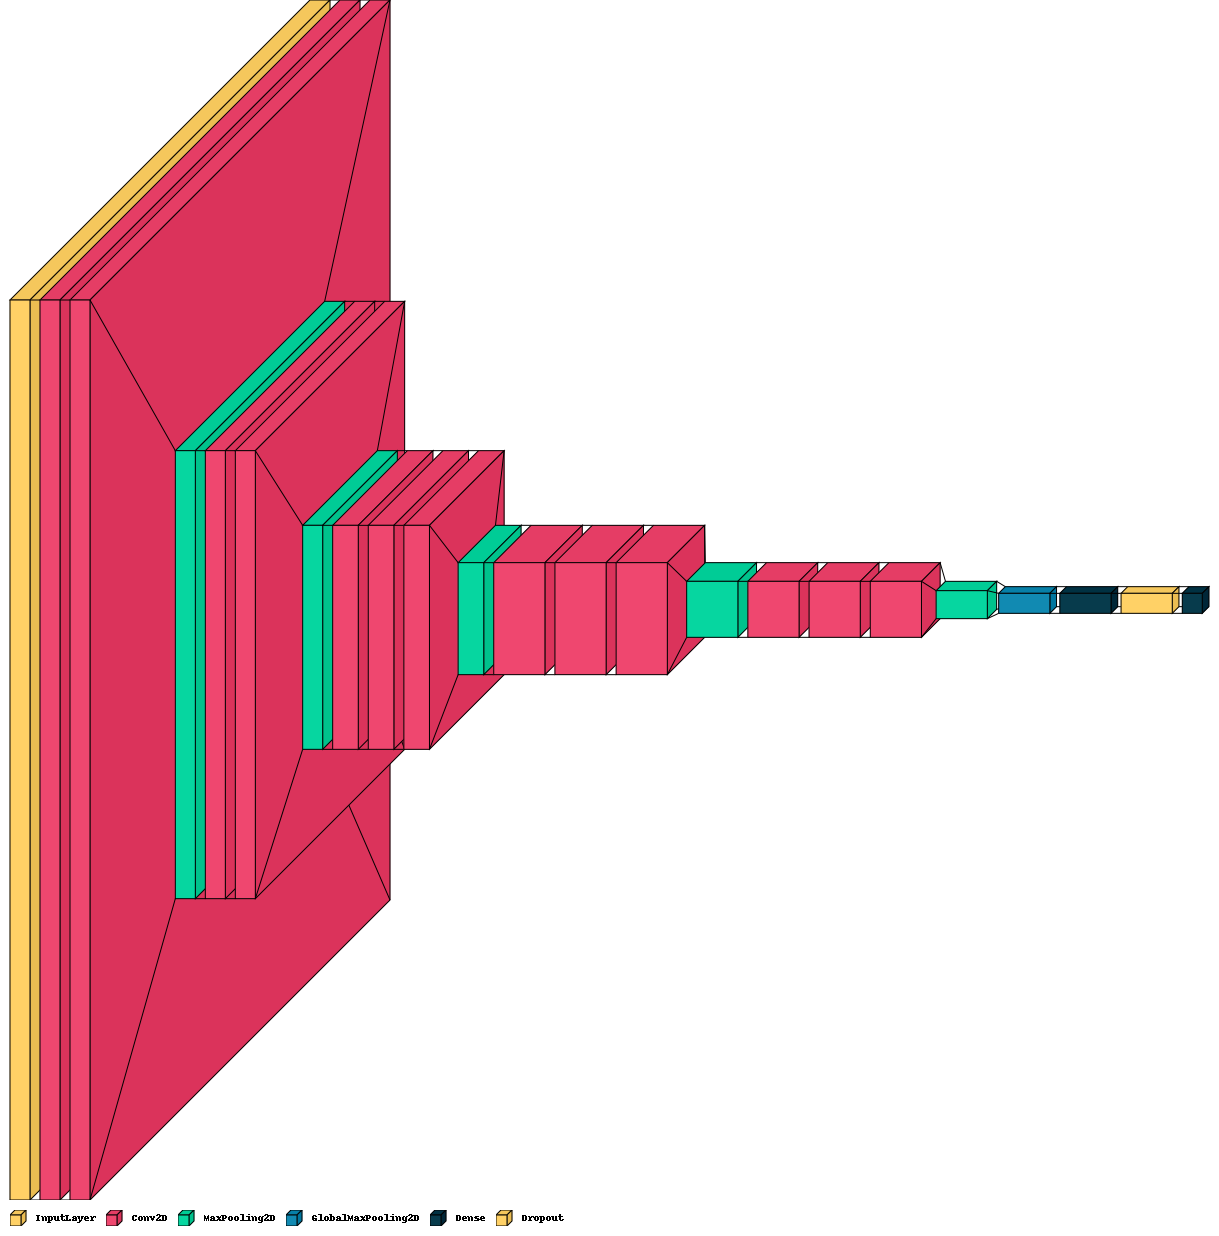

In [ ]:
!pip install visualkeras
import visualkeras
visualkeras.layered_view(model, legend=True)

In [ ]:
tuning_model=model.fit(training_generator,epochs=epochs,
                       validation_data=validation_generator,
                       validation_steps=validation_data.shape[0]//batch_size,
                       steps_per_epoch=training_data.shape[0]//batch_size)

Epoch 1/10
100/100 [==============================] - 1028s 10s/step - loss: 0.7086 - accuracy: 0.5913 - val_loss: 0.5011 - val_accuracy: 0.7862
Epoch 2/10
100/100 [==============================] - 55s 546ms/step - loss: 0.5071 - accuracy: 0.7519 - val_loss: 0.3532 - val_accuracy: 0.8700
Epoch 3/10
100/100 [==============================] - 54s 543ms/step - loss: 0.3847 - accuracy: 0.8344 - val_loss: 0.2718 - val_accuracy: 0.8913
Epoch 4/10
100/100 [==============================] - 55s 547ms/step - loss: 0.3076 - accuracy: 0.8766 - val_loss: 0.2314 - val_accuracy: 0.9038
Epoch 5/10
100/100 [==============================] - 55s 547ms/step - loss: 0.2748 - accuracy: 0.8828 - val_loss: 0.2112 - val_accuracy: 0.9075
Epoch 6/10
100/100 [==============================] - 55s 551ms/step - loss: 0.2480 - accuracy: 0.8966 - val_loss: 0.1994 - val_accuracy: 0.9150
Epoch 7/10
100/100 [==============================] - 55s 546ms/step - loss: 0.2302 - accuracy: 0.9025 - val_loss: 0.1873 - val_ac

## Evaluating model on `Accuracy` metric

In [ ]:
loss, accuracy = model.evaluate(training_generator, verbose=1)
print("Train : accuracy = %f  ;  loss = %f" % (accuracy, loss))

loss_v, accuracy_v = model.evaluate(validation_generator, verbose=1)
print("Validation : accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))

model.save("sample_4000_model.h5")

100/100 [==============================] - 53s 533ms/step - loss: 0.1647 - accuracy: 0.9322
Train : accuracy = 0.932187  ;  loss = 0.164737
25/25 [==============================] - 5s 191ms/step - loss: 0.1575 - accuracy: 0.9400
Validation : accuracy = 0.940000  ;  loss_v = 0.157548


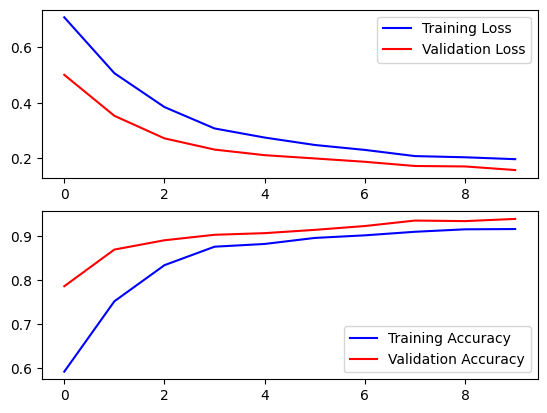

In [ ]:
fig,ax=plt.subplots(2,1)
ax[0].plot(tuning_model.history['loss'],color='blue',label='Training Loss')
ax[0].plot(tuning_model.history['val_loss'],color='red',label='Validation Loss',axes=ax[0])
ax[0].legend(loc='best')

ax[1].plot(tuning_model.history['accuracy'],color='blue',label='Training Accuracy')
ax[1].plot(tuning_model.history['val_accuracy'],color='red',label='Validation Accuracy',axes=ax[1])
ax[1].legend(loc='best')

## Testing model on `test_data`

Creating test_df

In [25]:
test_filenames=os.listdir("drive/MyDrive/dogs_vs_cats/data/test1")
test_df=pd.DataFrame({
    'Filename':test_filenames
})

test_df
sample_test_df=test_df[5089:5105]
sample_test_df

,Filename
5089,6449.jpg
5090,6469.jpg
5091,6468.jpg
5092,6529.jpg
5093,6516.jpg
5094,6530.jpg
5095,6536.jpg
5096,6506.jpg
5097,6532.jpg
5098,6520.jpg


In [16]:
new_model=tf.keras.models.load_model("drive/MyDrive/dogs_vs_cats/models/sample_4000_model.h5")

### Test Image Generator

In [1]:
test_datagen=ImageDataGenerator(rescale=1./255) # for rescaling image
test_generator=test_datagen.flow_from_dataframe(sample_test_df,"drive/MyDrive/dogs_vs_cats/data/test1",
                                                x_col='Filename',y_col=None,
                                                class_mode=None,batch_size=batch_size,
                                                target_size=(img_size,img_size),shuffle=False)


NameError: name 'ImageDataGenerator' is not defined

### Prediction on test data

In [28]:
%%time 
predict=new_model.predict_generator(test_generator,steps=np.ceil(test_df.shape[0]/batch_size))
threshold=0.5
sample_test_df['Category']=np.where(predict>threshold,1,0)

<timed exec>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


CPU times: user 2.68 s, sys: 47.4 ms, total: 2.73 s
Wall time: 12.7 s


<timed exec>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


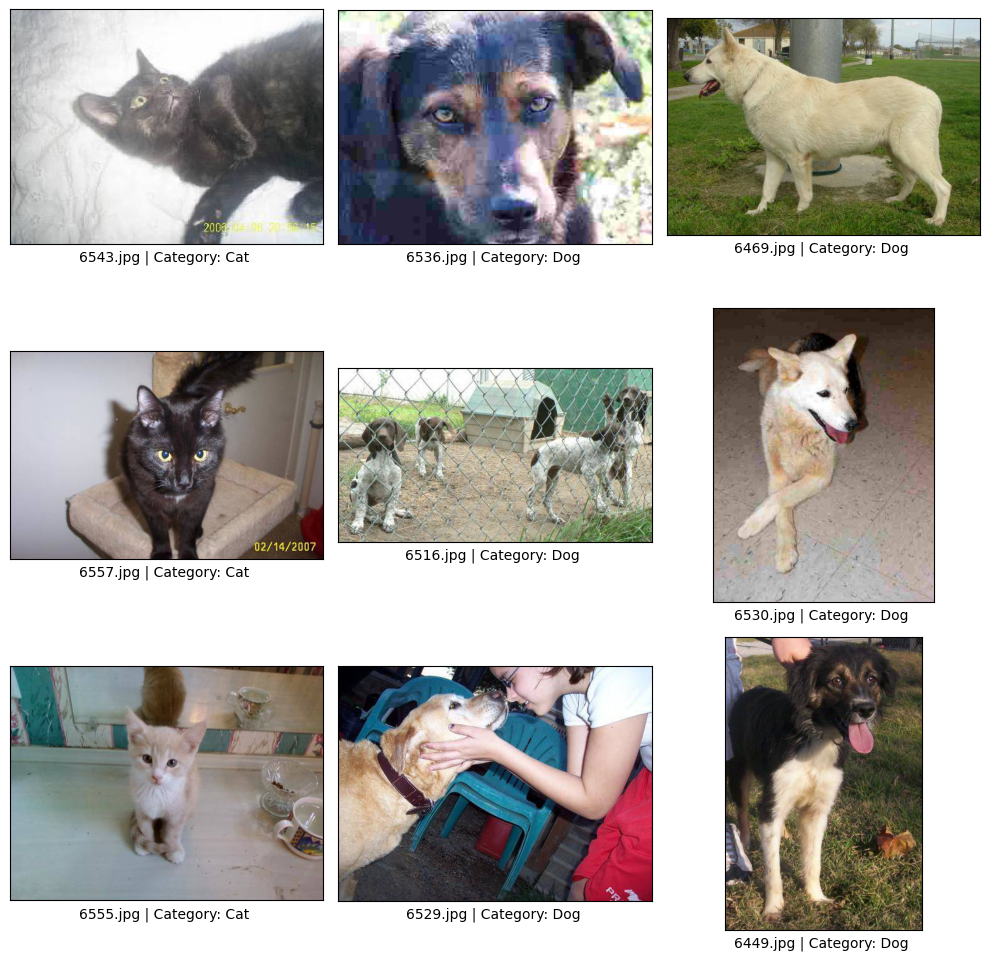

In [29]:
sample_test_df = sample_test_df.sample(n=9).reset_index(drop=True)
sample_test_df.head()
plt.figure(figsize=(10, 10))
for index, row in sample_test_df.iterrows():
    filename = row['Filename']
    category = 'Cat'if row['Category']==0 else 'Dog'
    img = np.asarray(Image.open("drive/MyDrive/dogs_vs_cats/data/test1/"+filename))
    plt.subplot(3, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + ' | Category: ' + "{}".format(category) + ' ')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()